## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. 

In [1]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [3]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [4]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [5]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_ic.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos    PI    MHI   FNI    SI
0   2020-01-01    1.289946  0.00   0.00  0.00  0.00
1   2020-01-02    0.735046  0.00   0.00  0.00  0.00
2   2020-01-03    0.591834  0.00   0.00  0.00  0.00
3   2020-01-04    1.367154  0.00   0.00  0.00  0.00
4   2020-01-05    1.505321  0.00   0.00  0.00  0.00
..         ...         ...   ...    ...   ...   ...
913 2022-07-02    0.778572  4.66  25.71  0.19 -3.56
914 2022-07-03    0.819483  0.42   7.76  0.00 -3.67
915 2022-07-04    0.843804  0.54  31.37  0.27 -5.85
916 2022-07-05    0.850985  0.48  38.21  0.12 -4.97
917 2022-07-06    0.840437  0.52  27.93  0.00 -7.87

[918 rows x 6 columns]

---

## Desarrollo del modelo

In [7]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [8]:
df_stats=df

In [9]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [10]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados

(273, 1)
(273, 19)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.23043946011121422
MAE is : 0.33954754687871036
RMSE is : 0.48004110252270504
MAPE is : 16.498810873870116
Evaluation metric results:
MSE is : 1.3876061611326034
MAE is : 0.9067091802607438
RMSE is : 1.1779669609681773
MAPE is : 45.98467319261372
(273, 1)
(273, 19)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.23683774320849676
MAE is : 0.35247708482636486
RMSE is : 0.4866597817865133
MAPE is : 17.364634325729558
Evaluation metric results:
MSE is : 1.3869161243985206
MAE is : 0.9040202523805685
RMSE is : 1.1776740314698804
MAPE is : 46.1803911519336
(273, 1)
(273, 19)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.23244897423780414
MAE is : 0.34898350649630105
RMSE is : 0.4821296238956948
MAPE is : 17.166064504657662
Evaluation metric results:
MSE is : 1.3774127335257609
MAE is : 0.9076964491457162
RMSE is : 1.1736322820738023
MAPE is : 46.659560230169504
(273, 1)
(273, 19)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22312759978987948
MAE is : 0.34503960019628455
RMSE is : 0.4723638425936933
MAPE is : 16.97792365122521
Evaluation metric results:
MSE is : 1.3967701681098543
MAE is : 0.9161055422397543
RMSE is : 1.1818503154417883
MAPE is : 47.145056760625195
(273, 1)
(273, 19)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22275591479902768
MAE is : 0.343974095340488
RMSE is : 0.47197024779007807
MAPE is : 16.837520015866037
Evaluation metric results:
MSE is : 1.3815808917110304
MAE is : 0.9081680798475641
RMSE is : 1.1754066920479185
MAPE is : 46.803455782997474
(271, 1)
(271, 29)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.25844285644620074
MAE is : 0.3558172390154701
RMSE is : 0.5083727534459344
MAPE is : 17.297726785802457
Evaluation metric results:
MSE is : 1.429822365457287
MAE is : 0.9257993466177299
RMSE is : 1.1957517992699351
MAPE is : 47.59381172237917
(271, 1)
(271, 29)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.22049160964884434
MAE is : 0.3422807498646681
RMSE is : 0.4695653411920905
MAPE is : 16.80463130187297
Evaluation metric results:
MSE is : 1.4318491331643026
MAE is : 0.9167690459134089
RMSE is : 1.1965989859448747
MAPE is : 47.76630643449866
(271, 1)
(271, 29)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.22408051569053933
MAE is : 0.3448857199491608
RMSE is : 0.4733714352287634
MAPE is : 16.89897284853743
Evaluation metric results:
MSE is : 1.4152794135345328
MAE is : 0.9155547392141884
RMSE is : 1.189655165808367
MAPE is : 47.3428416785418
(271, 1)
(271, 29)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.21960108299998712
MAE is : 0.34210881283937455
RMSE is : 0.4686161360858022
MAPE is : 16.70029396646596
Evaluation metric results:
MSE is : 1.3860764991023733
MAE is : 0.8964910653286862
RMSE is : 1.1773175013998447
MAPE is : 46.164724072623656
(271, 1)
(271, 29)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.22183159539132027
MAE is : 0.3431896848329978
RMSE is : 0.47099001623316844
MAPE is : 16.86440332614617
Evaluation metric results:
MSE is : 1.4062121617009133
MAE is : 0.9028734776996898
RMSE is : 1.185838168428101
MAPE is : 46.638467604219755
(269, 1)
(269, 39)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22487259132467008
MAE is : 0.3460876894283311
RMSE is : 0.47420732947168803
MAPE is : 17.181042943362787
Evaluation metric results:
MSE is : 1.4234130599347414
MAE is : 0.90708597381522
RMSE is : 1.1930687574212735
MAPE is : 45.97297728137249


<ipython-input-4-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])


(269, 1)
(269, 39)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22590736459400737
MAE is : 0.3493048662338357
RMSE is : 0.4752971329537002
MAPE is : 17.214300000113802
Evaluation metric results:
MSE is : 1.4465016653276777
MAE is : 0.932511487435255
RMSE is : 1.2027059762584027
MAPE is : 48.31441663505867
(269, 1)
(269, 39)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2225384262128454
MAE is : 0.3454843105966042
RMSE is : 0.47173978654852233
MAPE is : 17.04215642019137
Evaluation metric results:
MSE is : 1.4051158050921988
MAE is : 0.9094238005887731
RMSE is : 1.1853758075362424
MAPE is : 46.590653816020854
(269, 1)
(269, 39)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22586523959568555
MAE is : 0.34452843532112687
RMSE is : 0.47525281650473733
MAPE is : 16.971314917492563
Evaluation metric results:
MSE is : 1.3994354264590676
MAE is : 0.9054477363204341
RMSE is : 1.1829773566975268
MAPE is : 46.57748899940001
(269, 1)
(269, 39)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21886158821398333
MAE is : 0.34152797185231426
RMSE is : 0.46782645095588954
MAPE is : 16.778149775317235
Evaluation metric results:
MSE is : 1.3850378780424977
MAE is : 0.9025534311567199
RMSE is : 1.1768763223221452
MAPE is : 46.19868209926874
(268, 1)
(268, 44)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.24761817696729493
MAE is : 0.3543346439713838
RMSE is : 0.49761247669978587
MAPE is : 17.493291783460084
Evaluation metric results:
MSE is : 1.3979083445337193
MAE is : 0.900546233806806
RMSE is : 1.1823317404746094
MAPE is : 46.173241585367045
(268, 1)
(268, 44)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.22310078726749014
MAE is : 0.3442031704722552
RMSE is : 0.47233546052301656
MAPE is : 16.918626025113426
Evaluation metric results:
MSE is : 1.441172785118139
MAE is : 0.9261989664847247
RMSE is : 1.200488561010949
MAPE is : 48.05106834463154
(268, 1)
(268, 44)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.2307548213437559
MAE is : 0.34785062864079414
RMSE is : 0.4803694633755938
MAPE is : 17.14226036222061
Evaluation metric results:
MSE is : 1.407749235865003
MAE is : 0.9096799883563507
RMSE is : 1.186486087514305
MAPE is : 46.6196990917774
(268, 1)
(268, 44)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.2231173735160746
MAE is : 0.34200980162145295
RMSE is : 0.47235301789665174
MAPE is : 16.753309563616263
Evaluation metric results:
MSE is : 1.387284384770254
MAE is : 0.9040941635981781
RMSE is : 1.1778303718151668
MAPE is : 46.33855119590885
(268, 1)
(268, 44)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.22231066215374354
MAE is : 0.34243702803835185
RMSE is : 0.47149831617275534
MAPE is : 16.839997649865968
Evaluation metric results:
MSE is : 1.3787549200894154
MAE is : 0.9020834072130702
RMSE is : 1.174203951658065
MAPE is : 46.002549884174215
(266, 1)
(266, 54)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.242552021143955
MAE is : 0.346420484331778
RMSE is : 0.49249570672641907
MAPE is : 16.9515404584247
Evaluation metric results:
MSE is : 1.4399223762541
MAE is : 0.9178547025912899
RMSE is : 1.1999676563366615
MAPE is : 47.74090729677645
(266, 1)
(266, 54)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2363565037288952
MAE is : 0.34788658833503366
RMSE is : 0.4861650992501366
MAPE is : 17.07497401817354
Evaluation metric results:
MSE is : 1.4467142465474239
MAE is : 0.9257479024664436
RMSE is : 1.2027943492332445
MAPE is : 48.100297291409895
(266, 1)
(266, 54)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.23398731184053154
MAE is : 0.34567802473761455
RMSE is : 0.4837223499493605
MAPE is : 16.973456021967976
Evaluation metric results:
MSE is : 1.4225979844417904
MAE is : 0.9140591660603836
RMSE is : 1.19272712069517
MAPE is : 46.989473200236084
(266, 1)
(266, 54)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.21807836466495373
MAE is : 0.33971136523208634
RMSE is : 0.46698861299281563
MAPE is : 16.74086454042846
Evaluation metric results:
MSE is : 1.4459701979984114
MAE is : 0.9294638288658975
RMSE is : 1.202485009469312
MAPE is : 47.940279722696445
(266, 1)
(266, 54)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2275495234140131
MAE is : 0.3434781350325772
RMSE is : 0.47702151252748876
MAPE is : 16.789751599027266
Evaluation metric results:
MSE is : 1.4298999268197934
MAE is : 0.9169954108816368
RMSE is : 1.1957842308793813
MAPE is : 47.068084891027276
(261, 1)
(261, 79)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.23454036475223533
MAE is : 0.35130628393786656
RMSE is : 0.48429367614313873
MAPE is : 17.18784261089805
Evaluation metric results:
MSE is : 1.4179942193596011
MAE is : 0.9257665160582232
RMSE is : 1.1907956245131242
MAPE is : 47.307289345513425
(261, 1)
(261, 79)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.2182626527225174
MAE is : 0.3406725619072018
RMSE is : 0.46718588669020966
MAPE is : 16.70422864166331
Evaluation metric results:
MSE is : 1.4482517529236179
MAE is : 0.9276495332153729
RMSE is : 1.2034333188521988
MAPE is : 48.27497630029977
(261, 1)
(261, 79)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.231233604904563
MAE is : 0.34506203426613885
RMSE is : 0.48086755443111673
MAPE is : 16.84449895506739
Evaluation metric results:
MSE is : 1.4051764323688716
MAE is : 0.9122057140313452
RMSE is : 1.1854013802796384
MAPE is : 47.00746316308113
(261, 1)
(261, 79)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.22153177031889285
MAE is : 0.3435096723029291
RMSE is : 0.4706716162239793
MAPE is : 16.972235087568357
Evaluation metric results:
MSE is : 1.401183507014778
MAE is : 0.9119855155640353
RMSE is : 1.183715973962833
MAPE is : 47.08101151796688
(261, 1)
(261, 79)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.2266822923009436
MAE is : 0.3448975980771979
RMSE is : 0.4761116384850759
MAPE is : 16.88819238295571
Evaluation metric results:
MSE is : 1.3885519570750415
MAE is : 0.9134310869837459
RMSE is : 1.178368345244831
MAPE is : 47.29612011600851


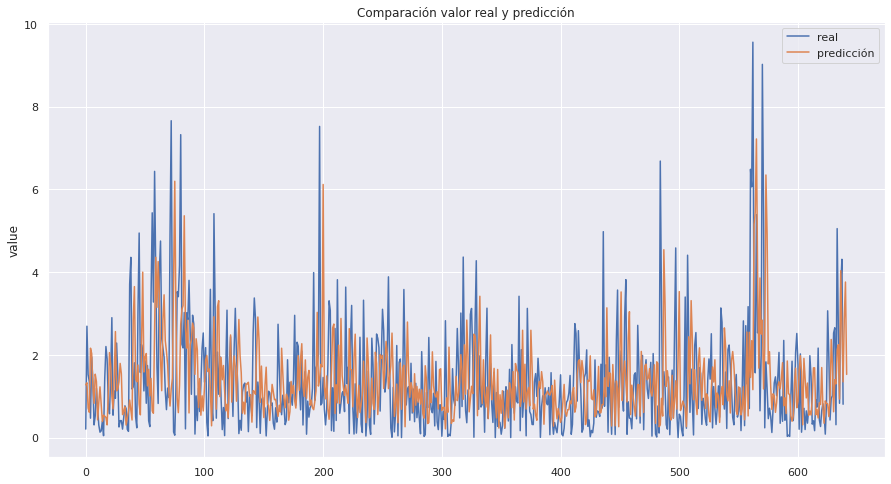

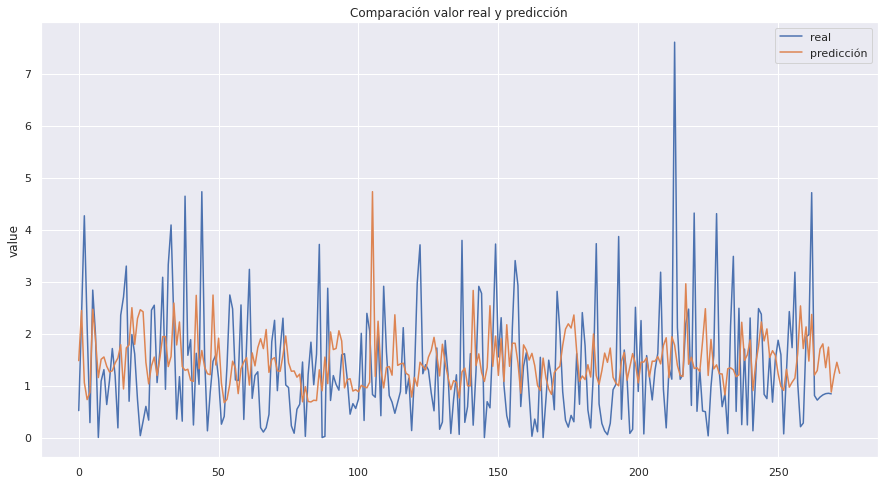

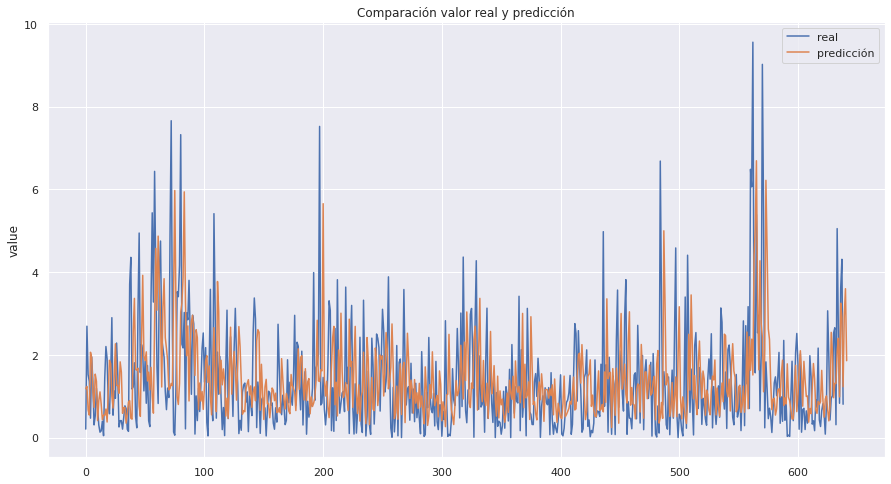

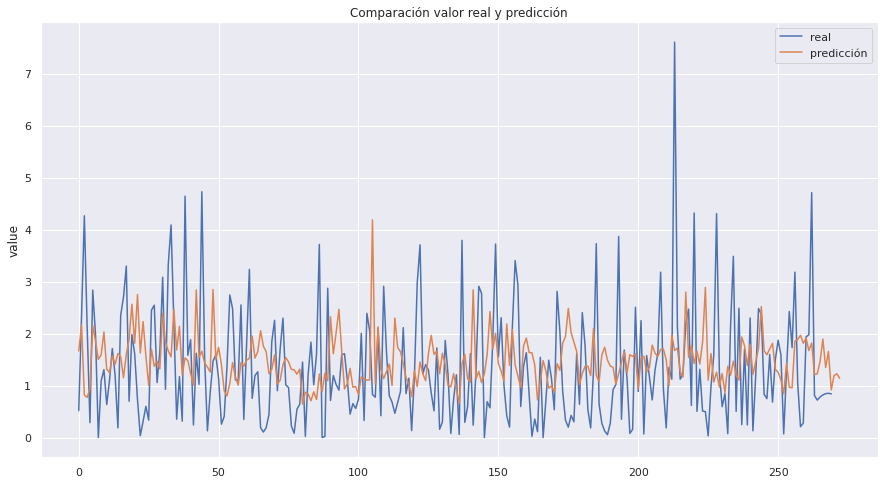

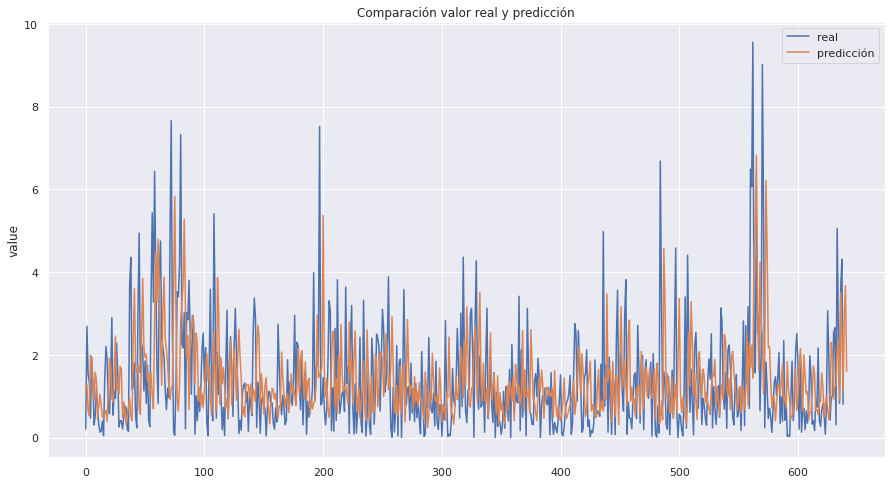

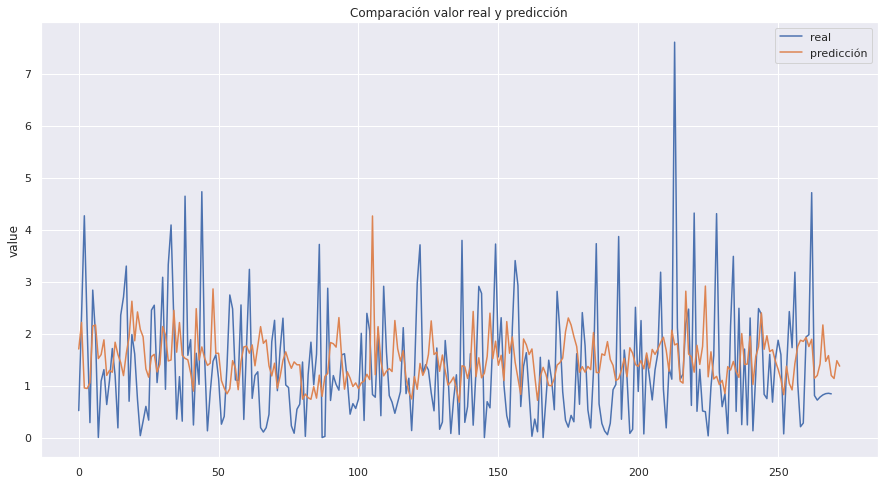

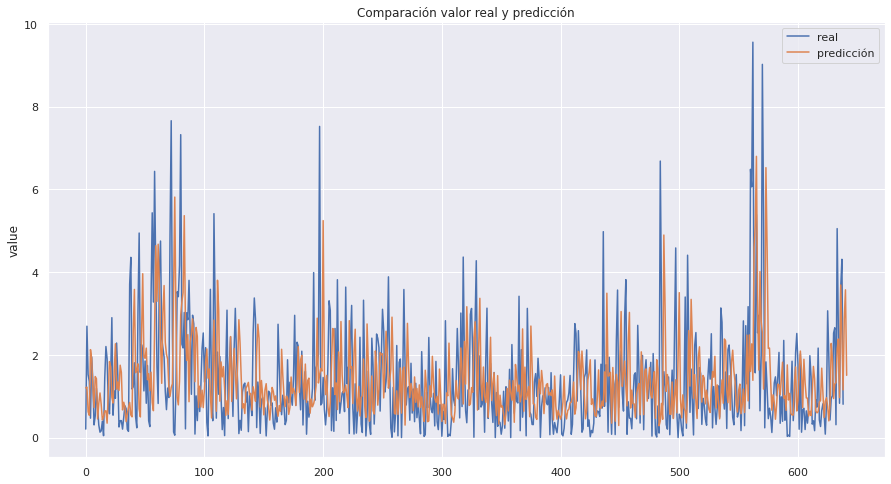

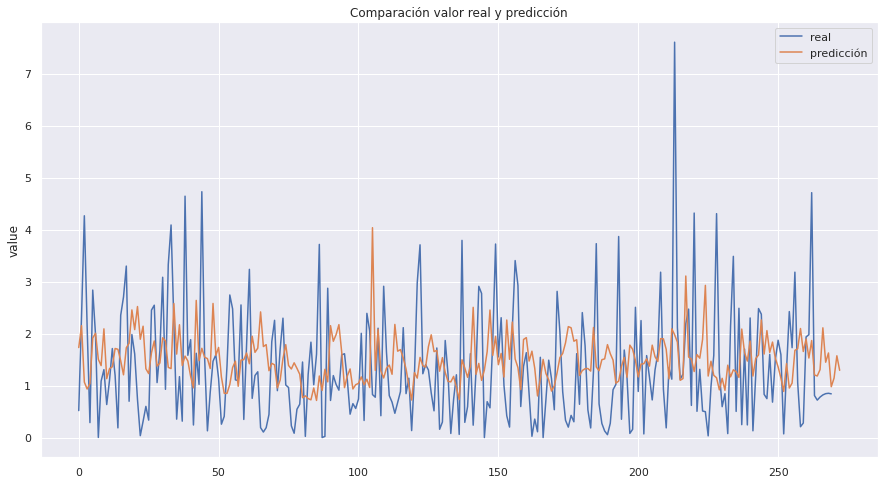

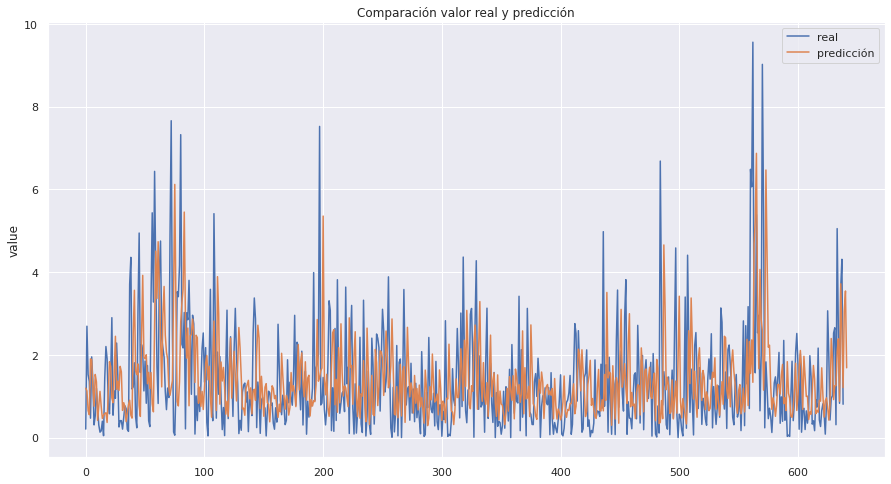

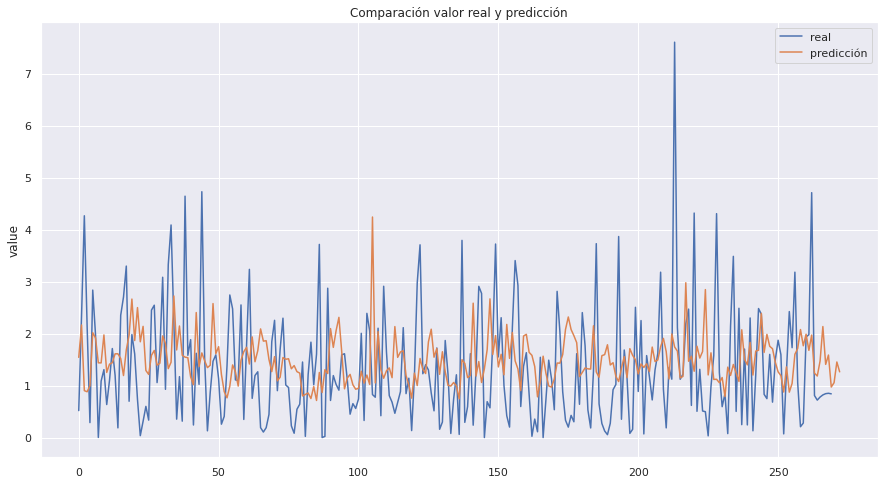

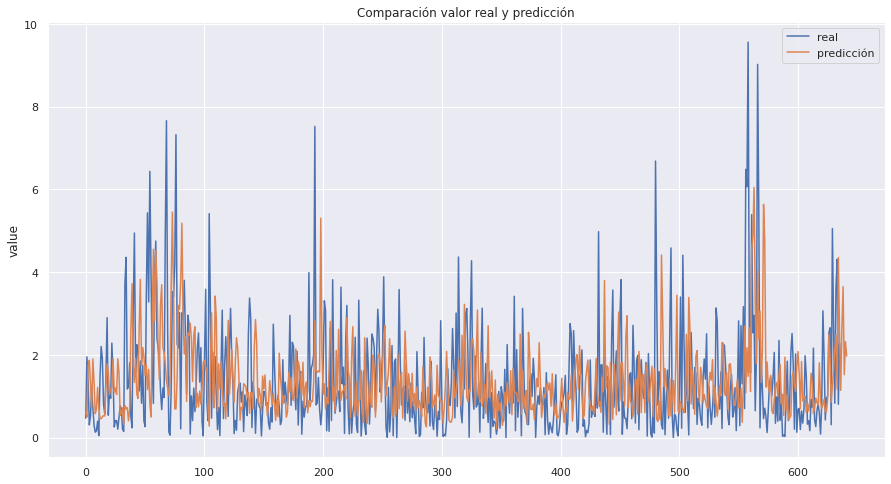

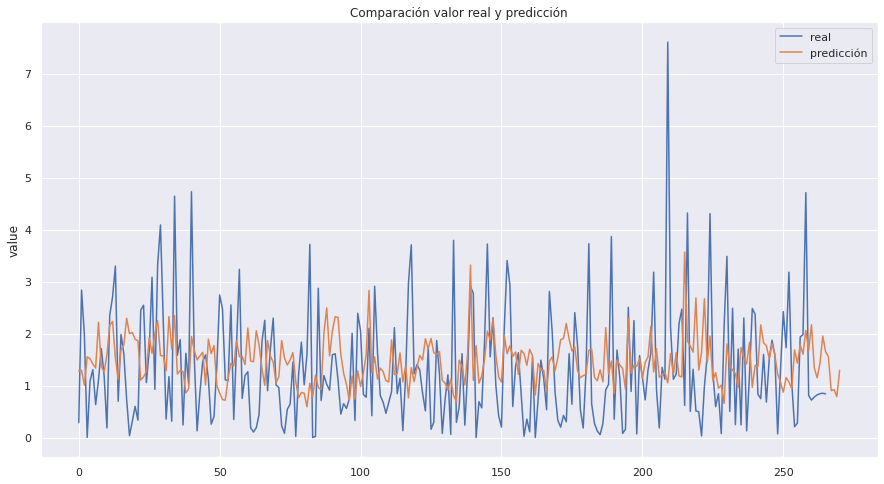

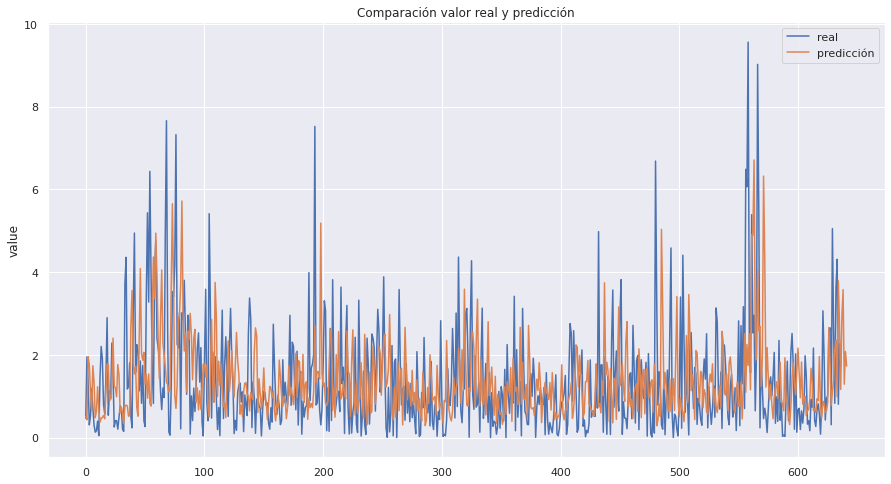

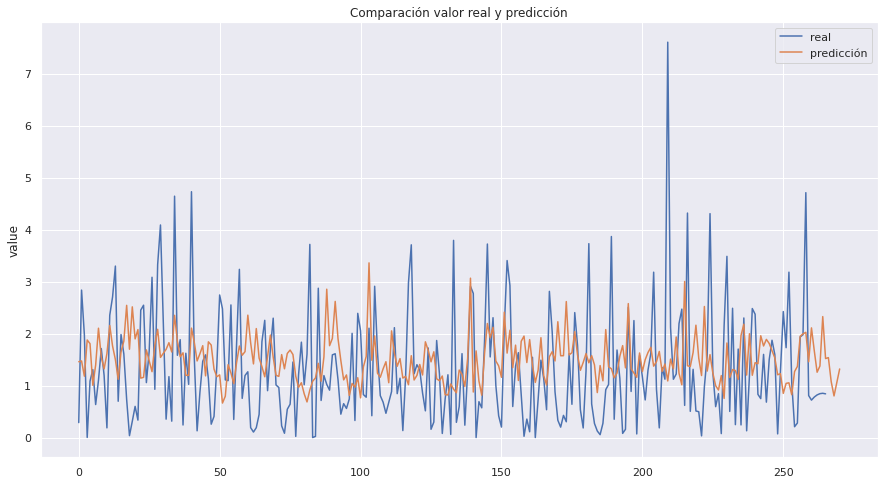

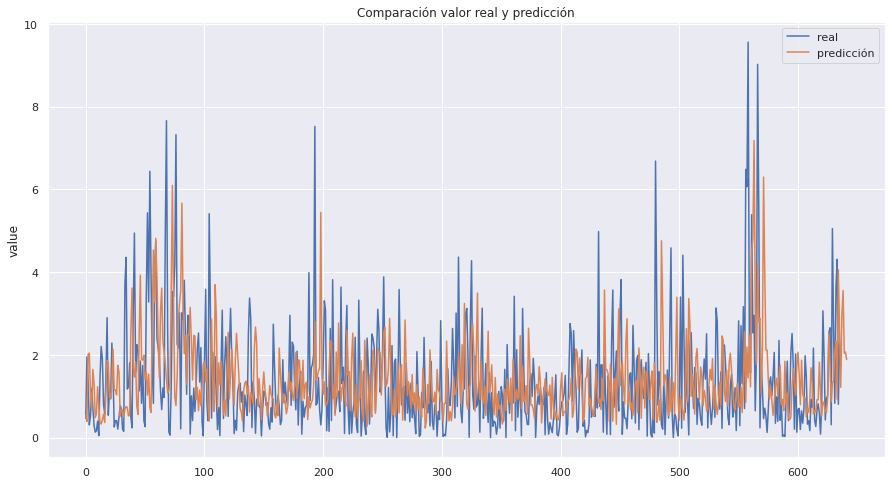

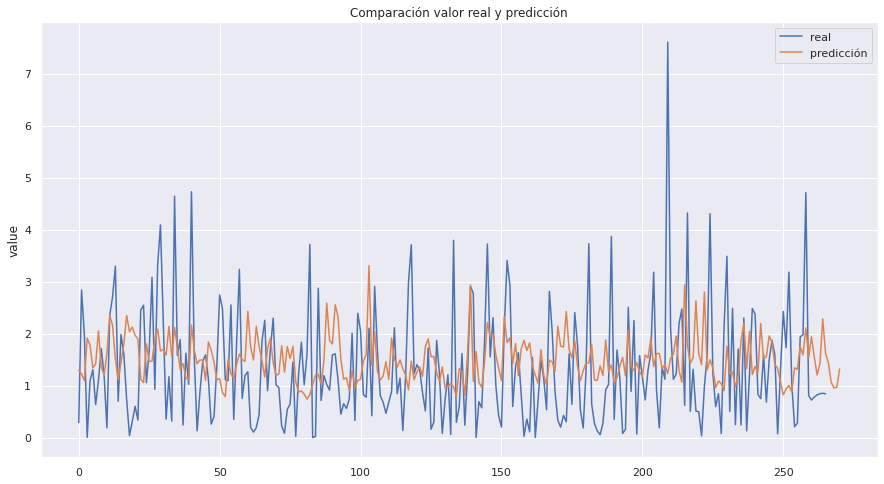

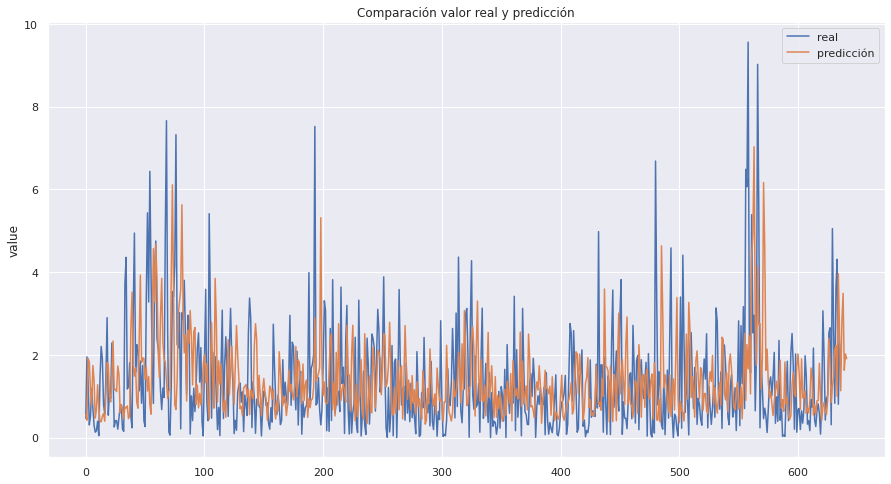

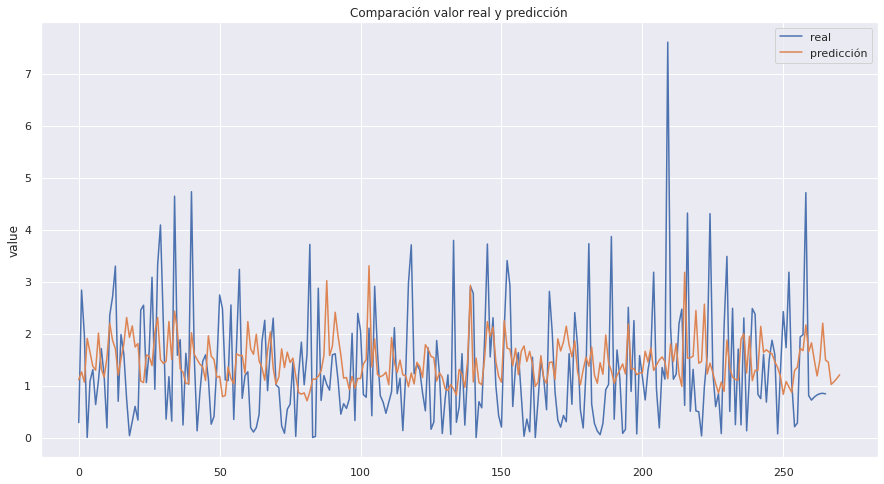

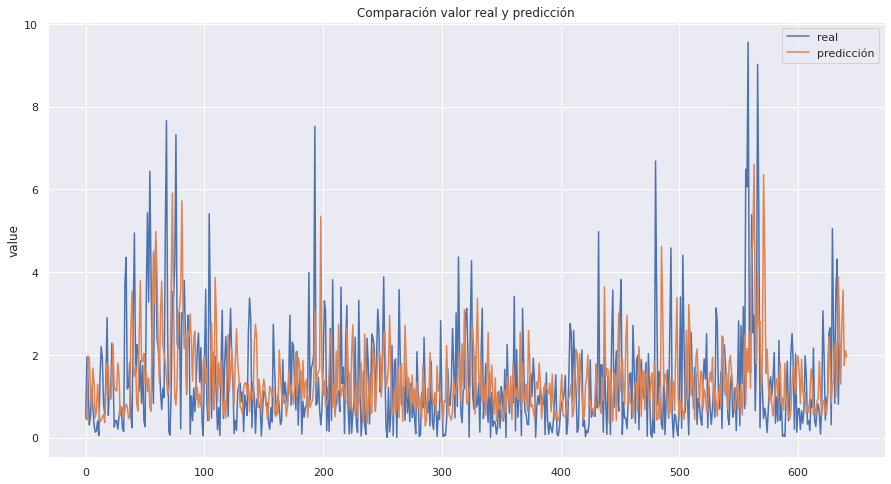

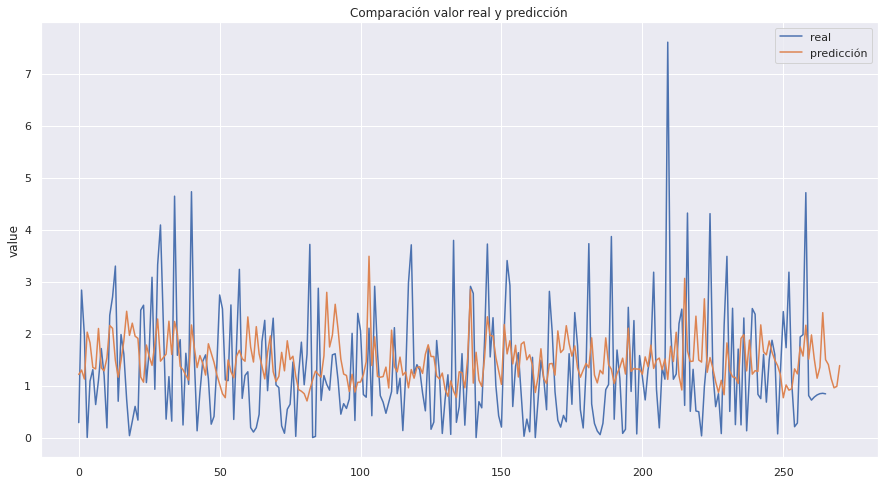

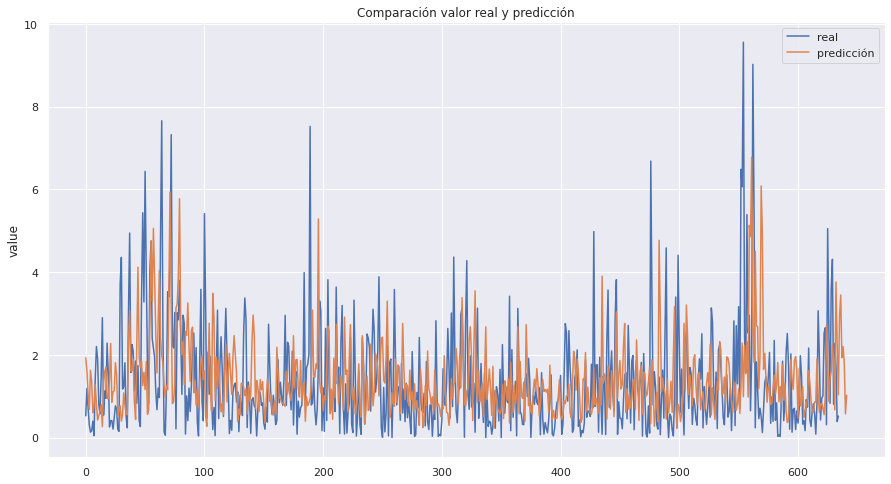

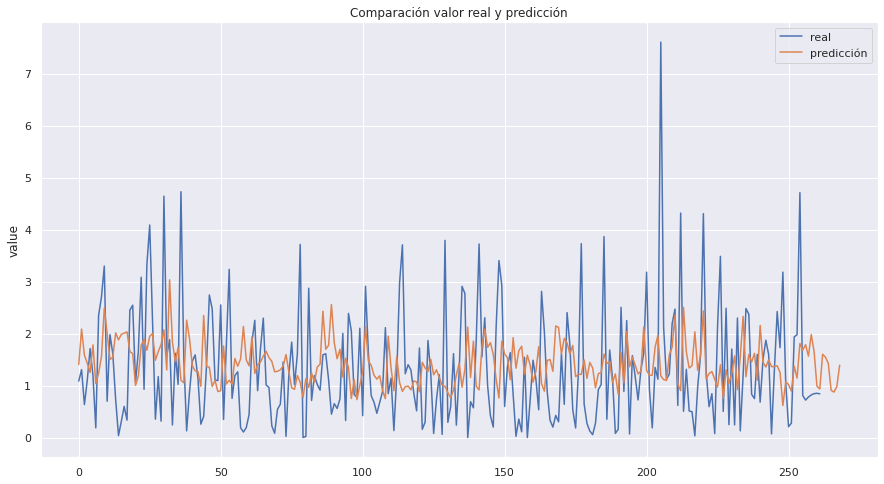

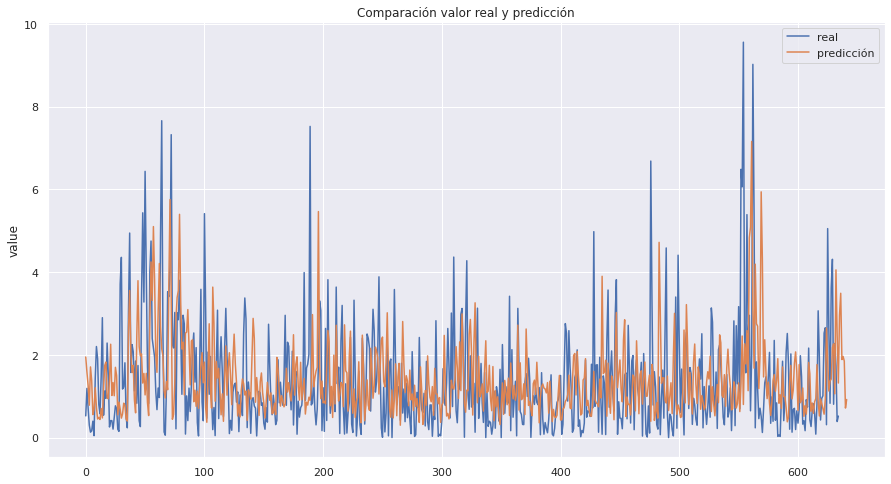

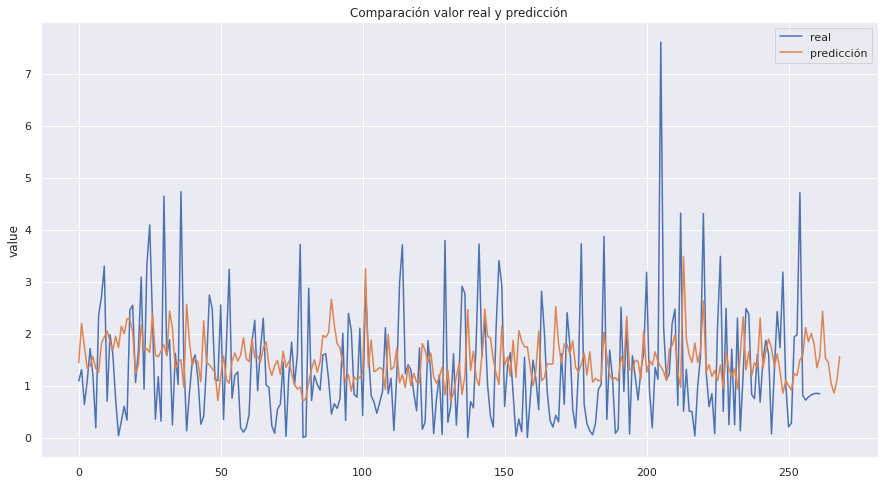

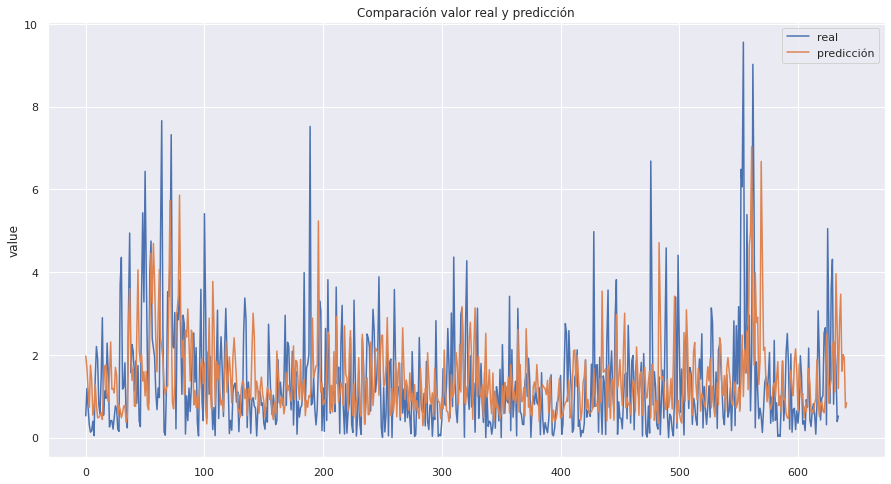

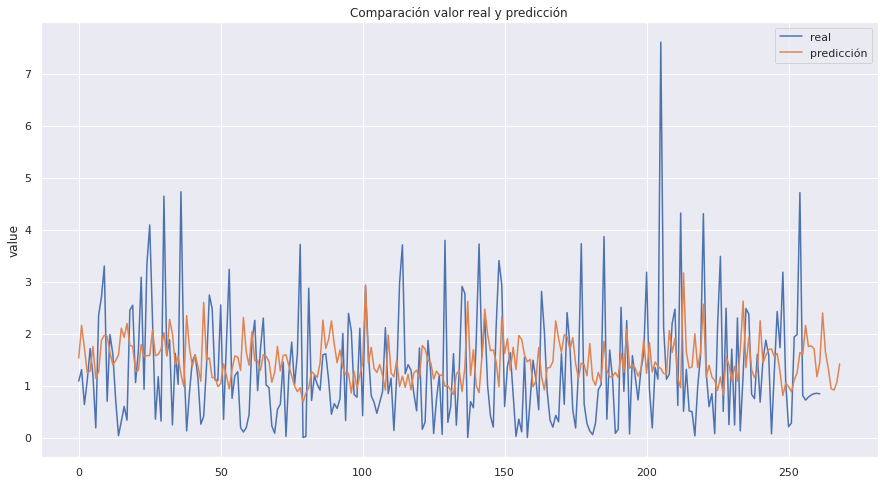

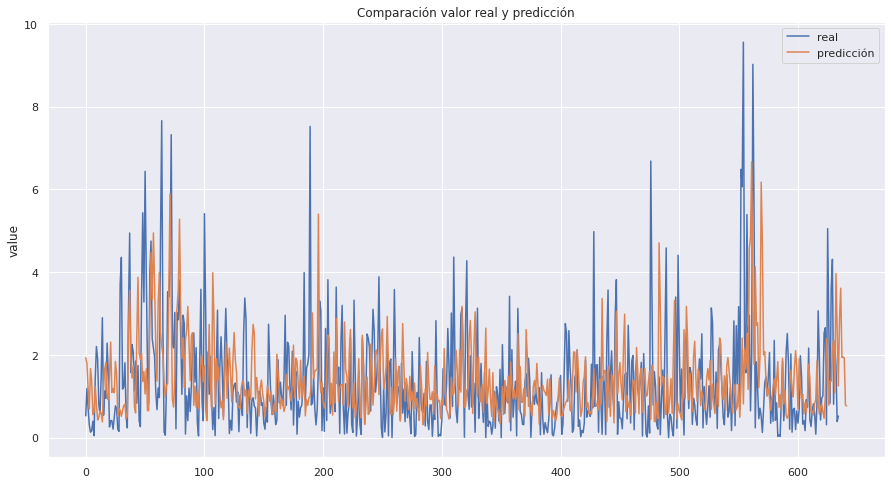

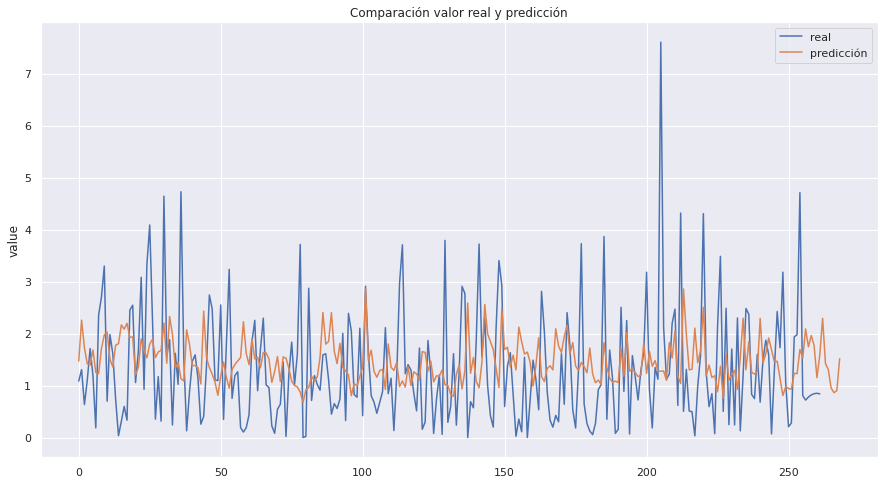

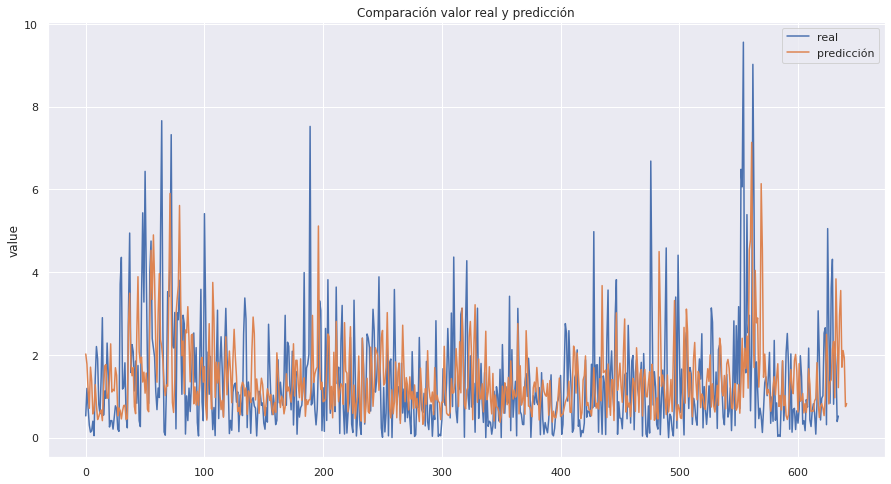

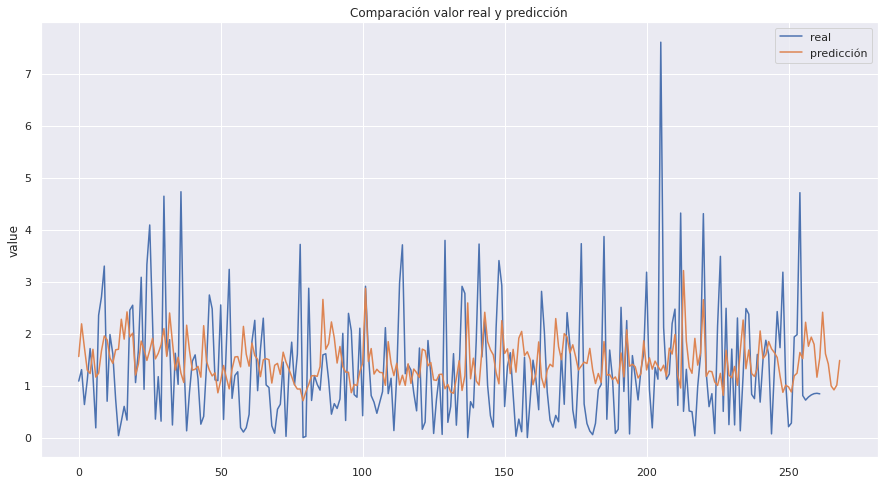

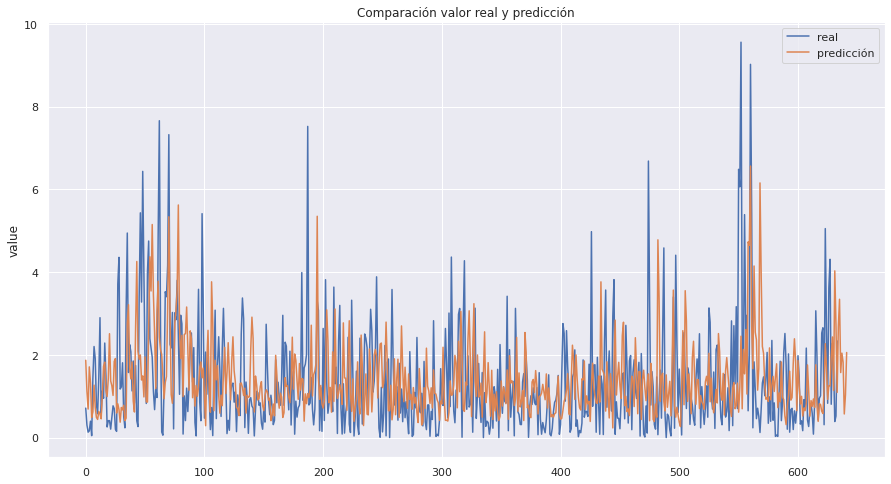

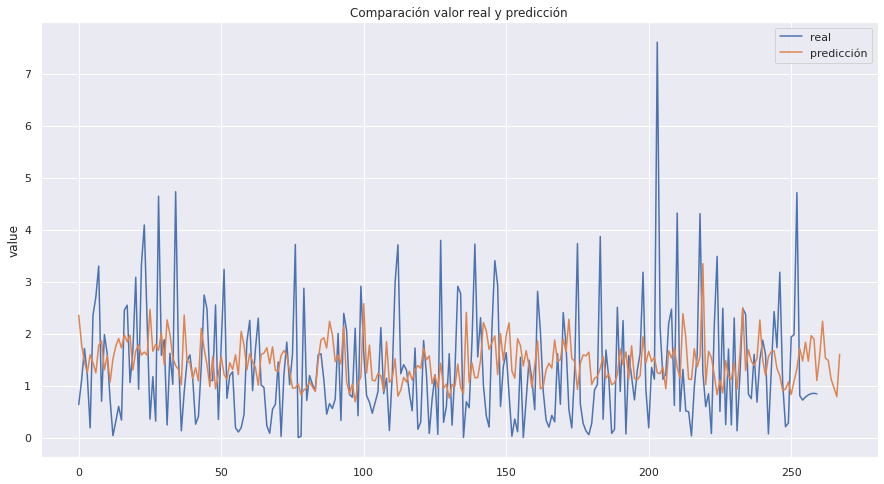

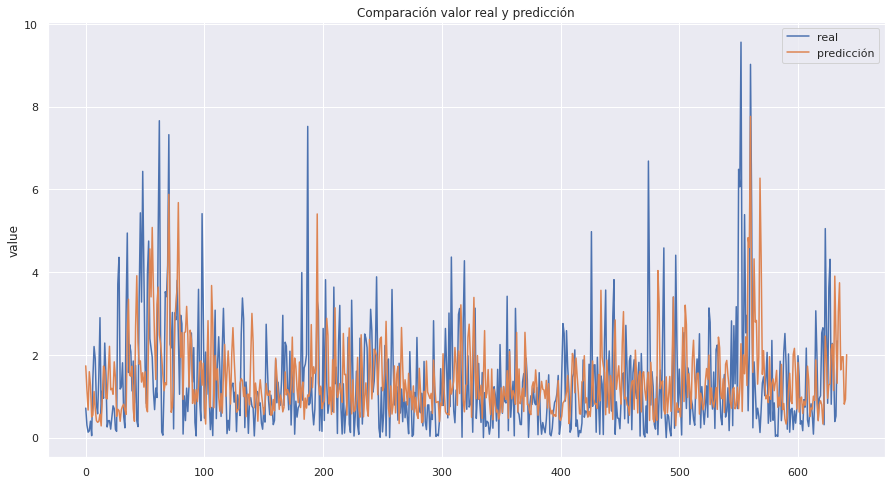

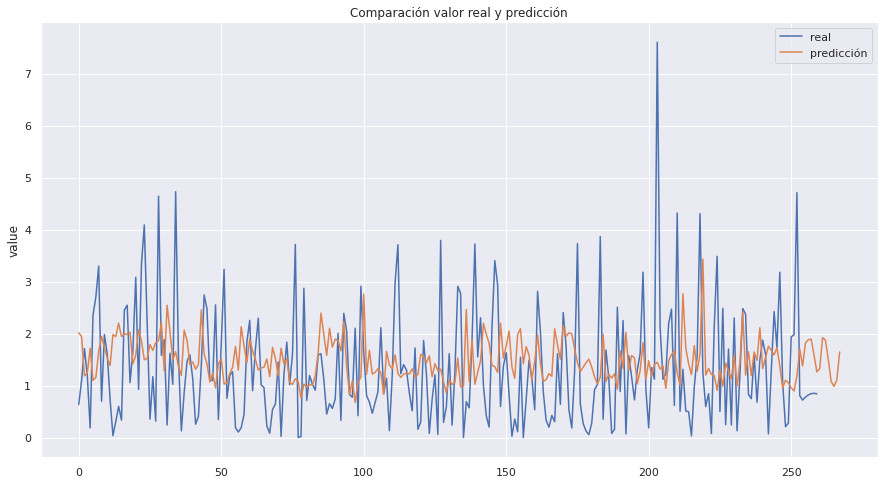

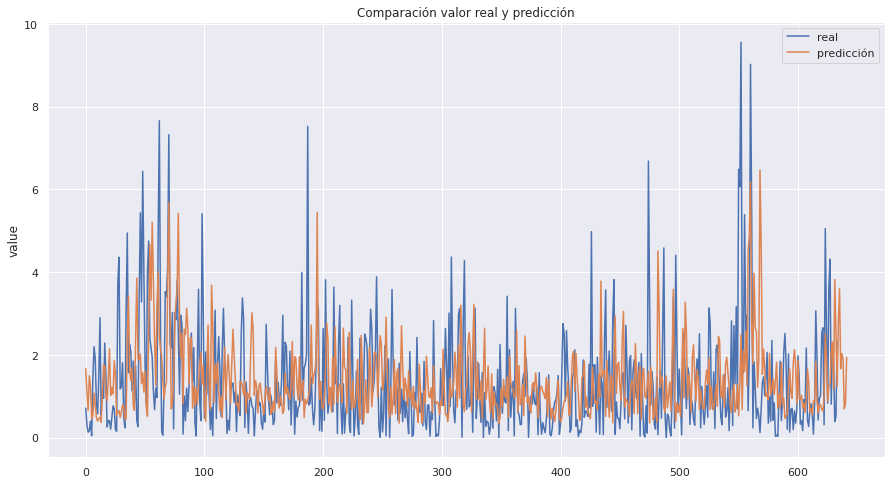

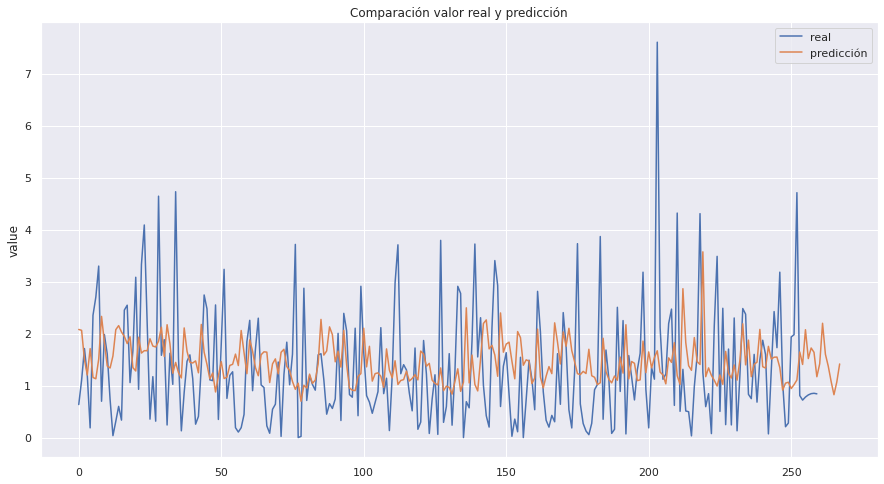

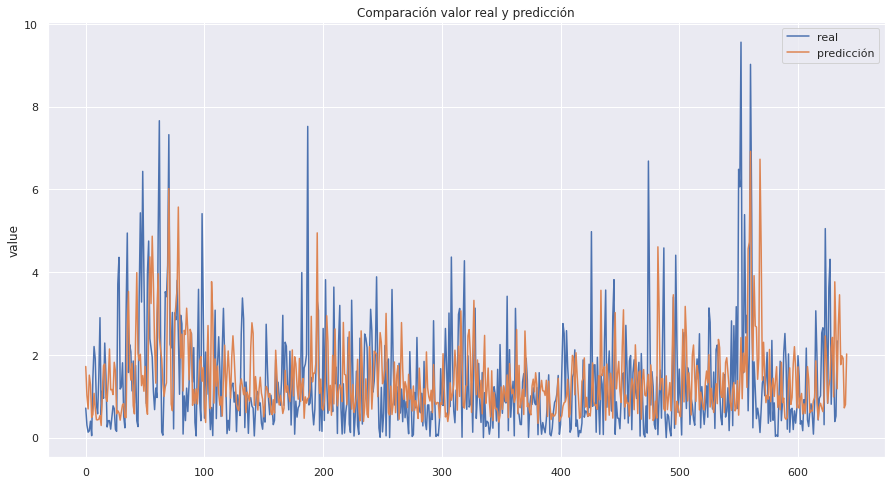

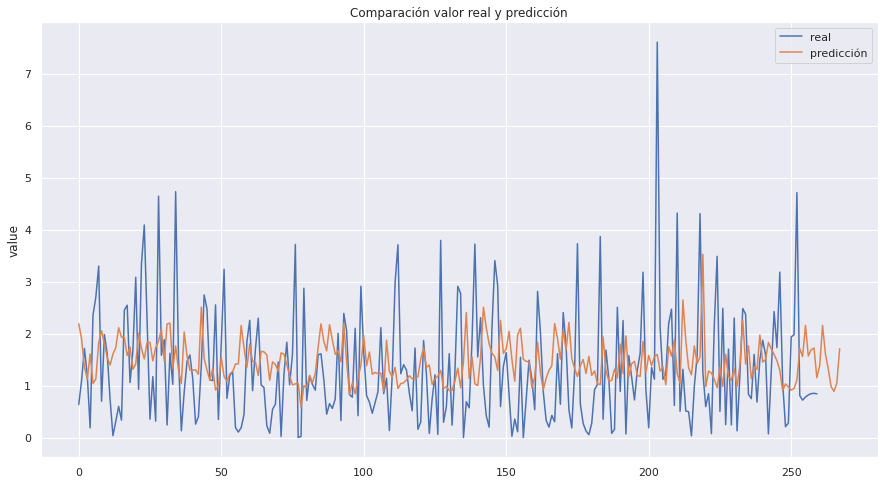

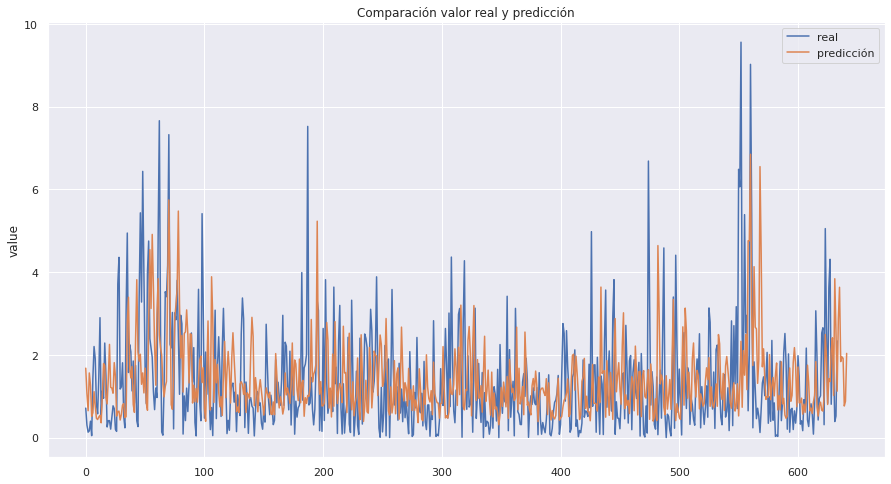

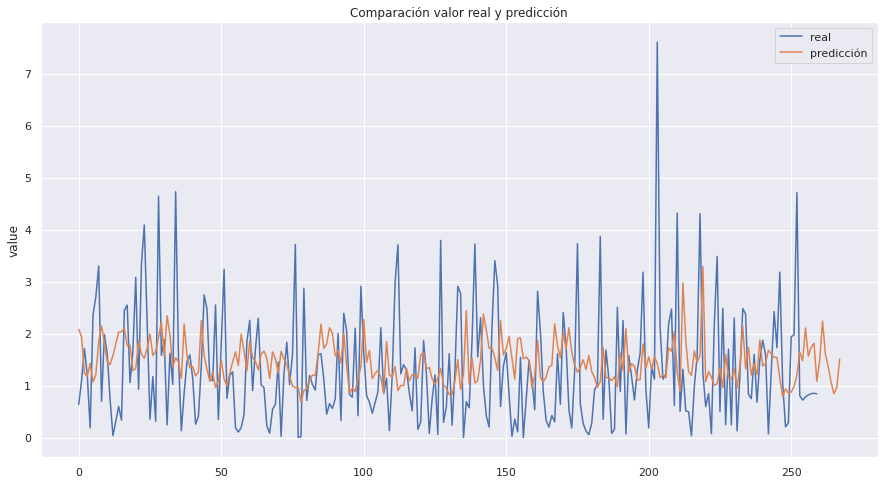

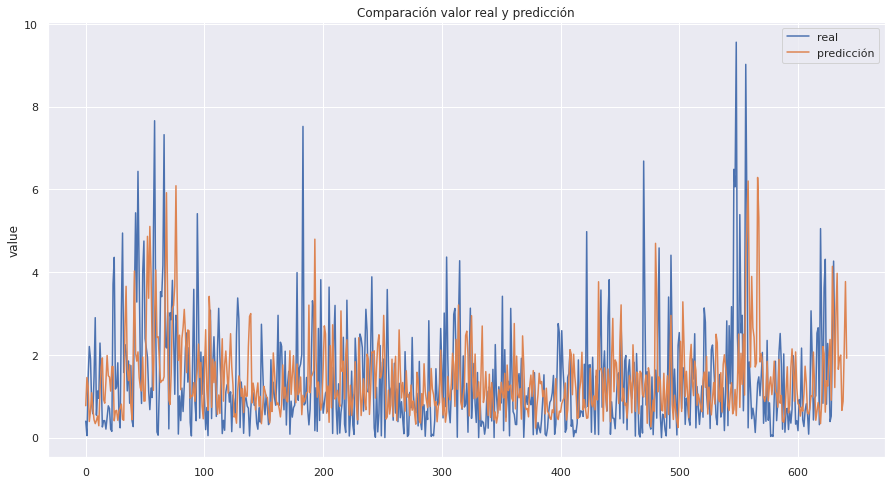

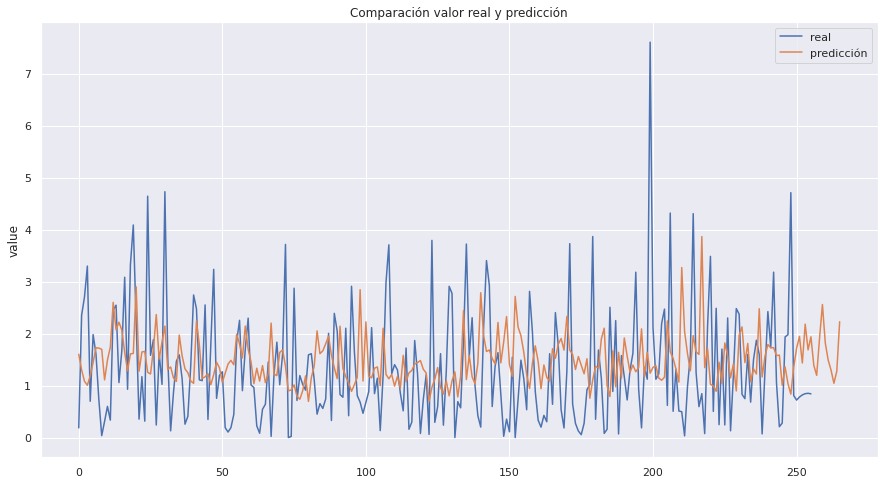

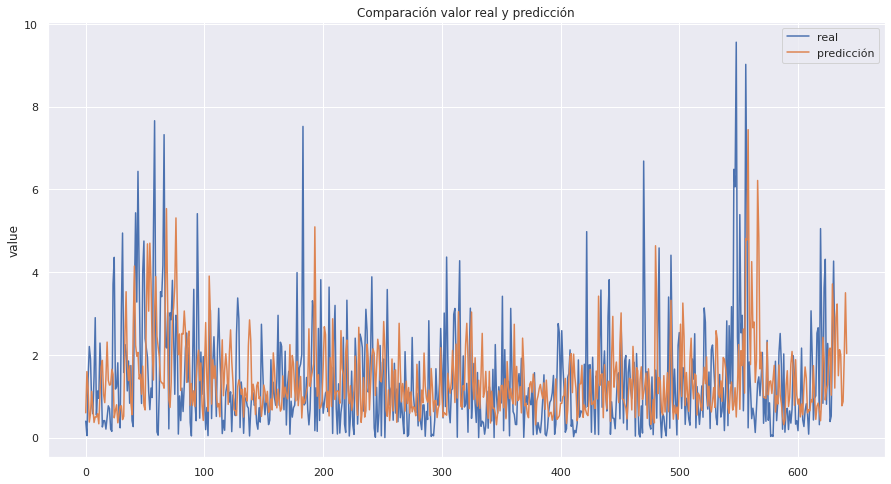

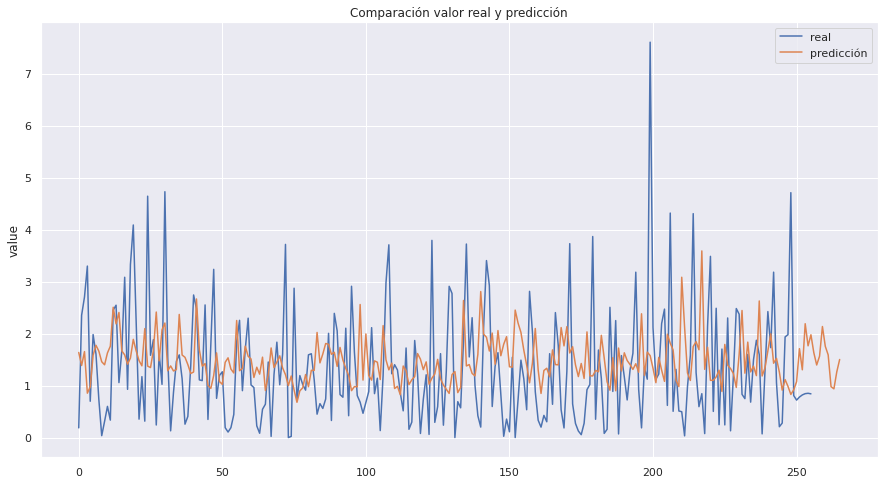

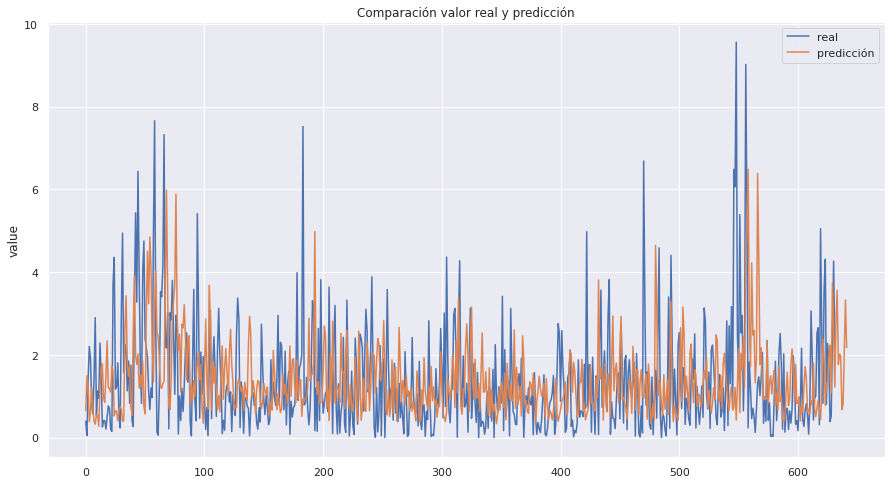

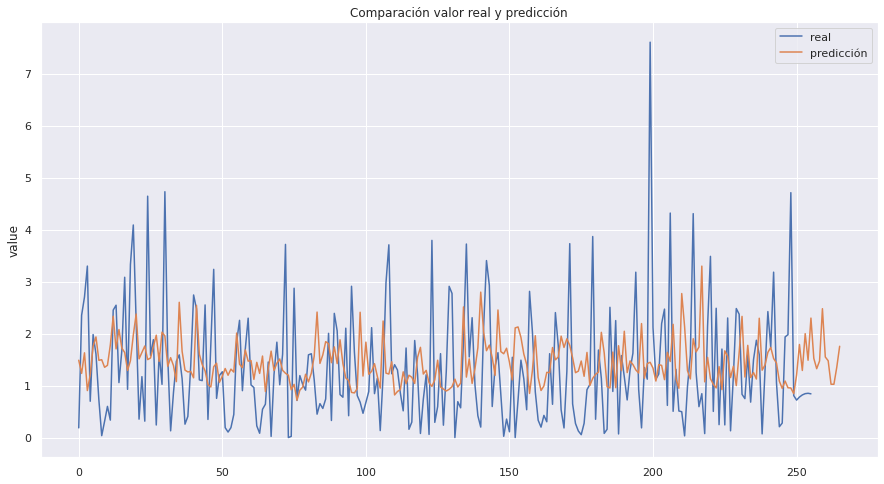

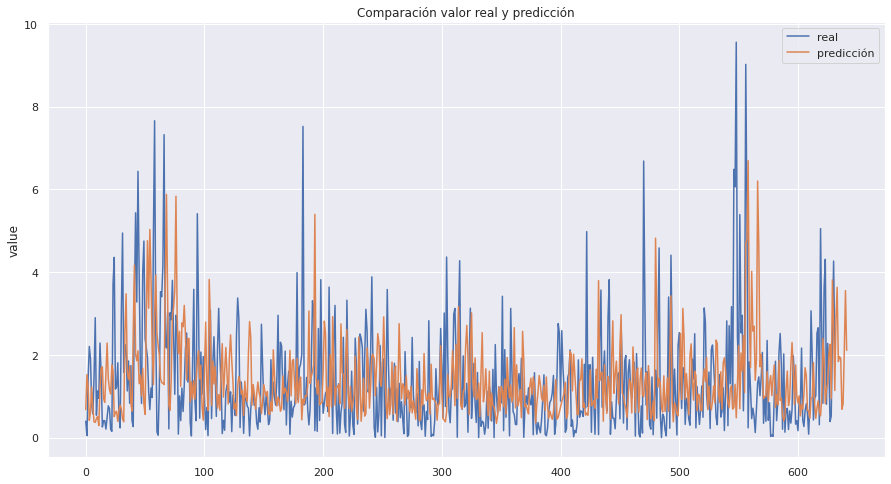

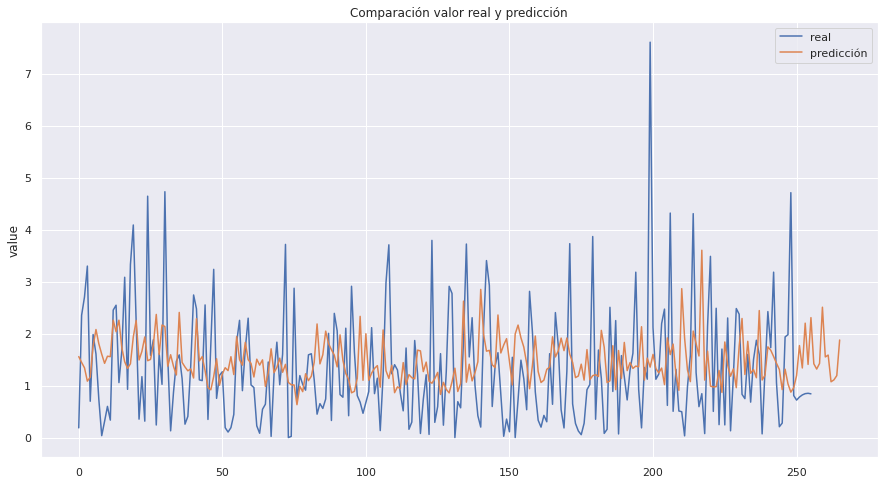

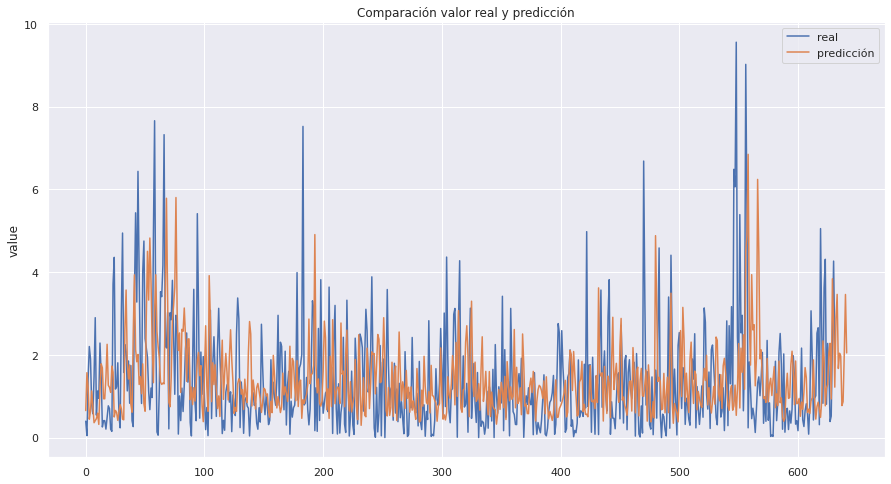

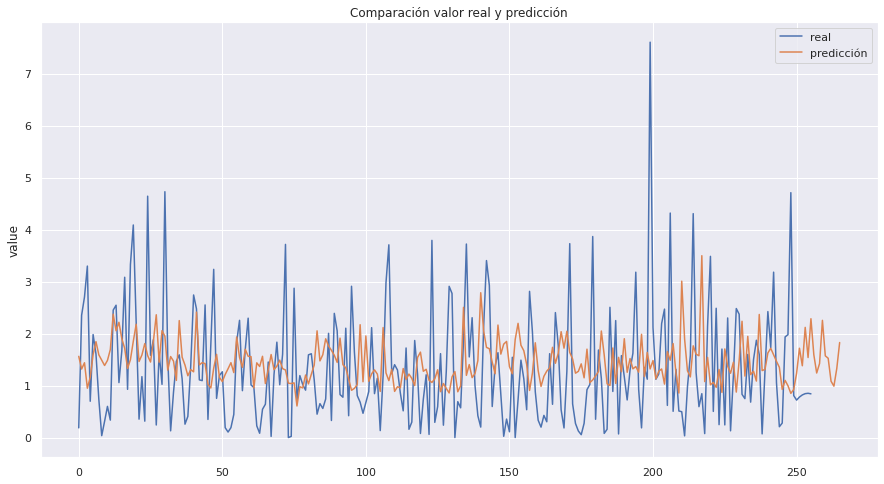

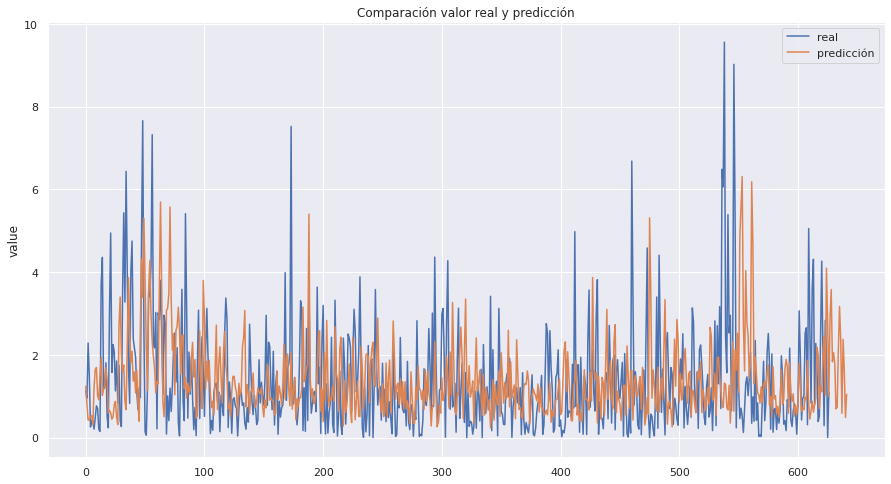

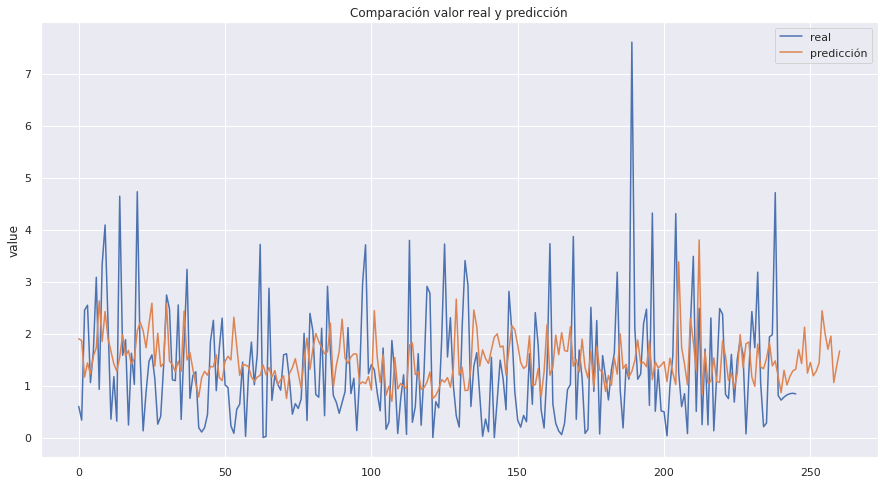

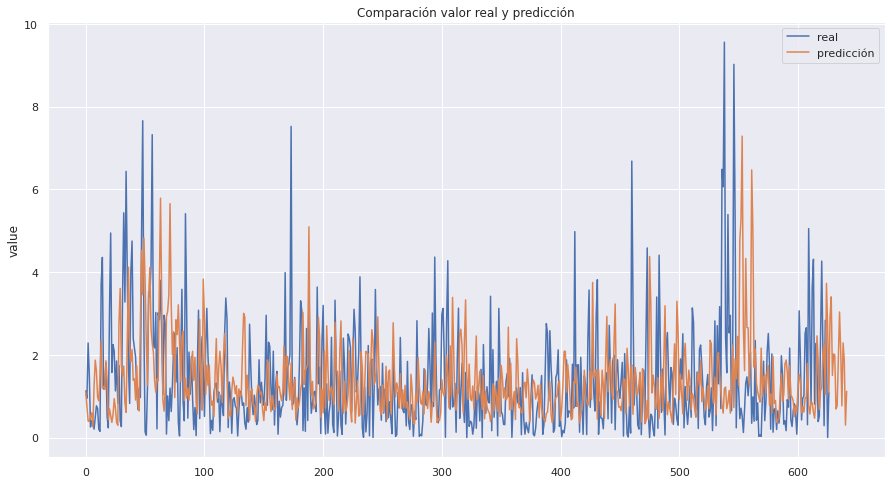

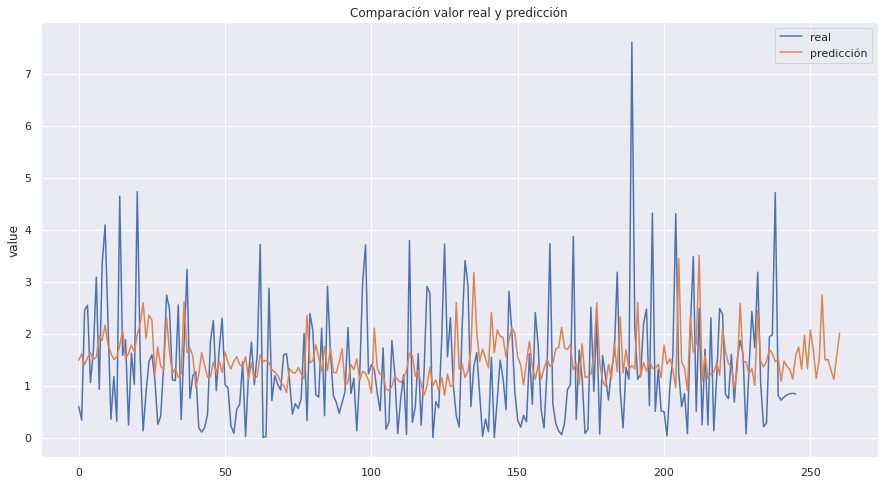

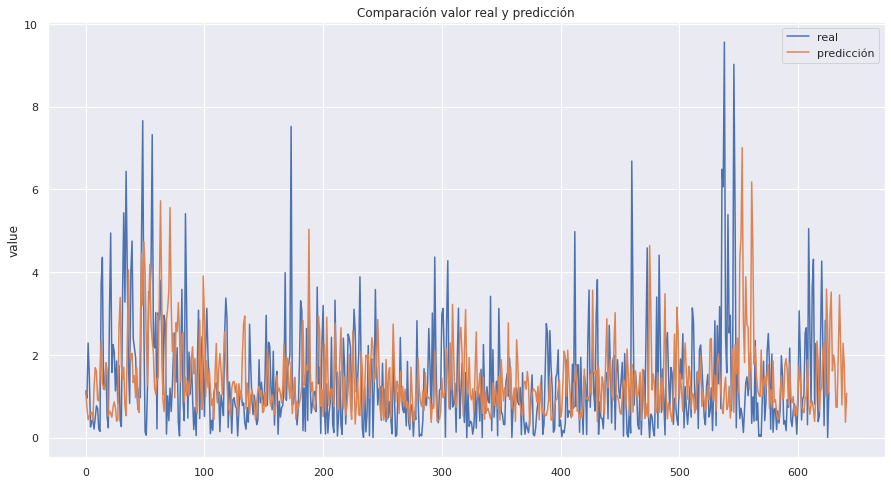

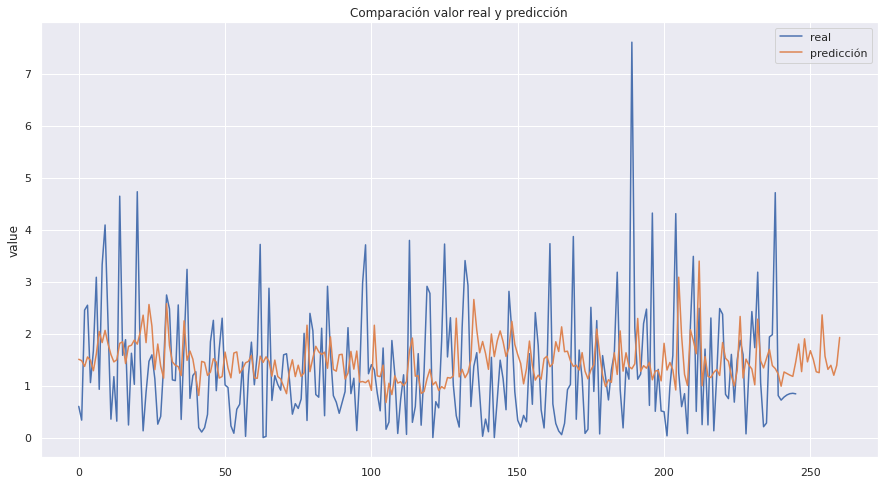

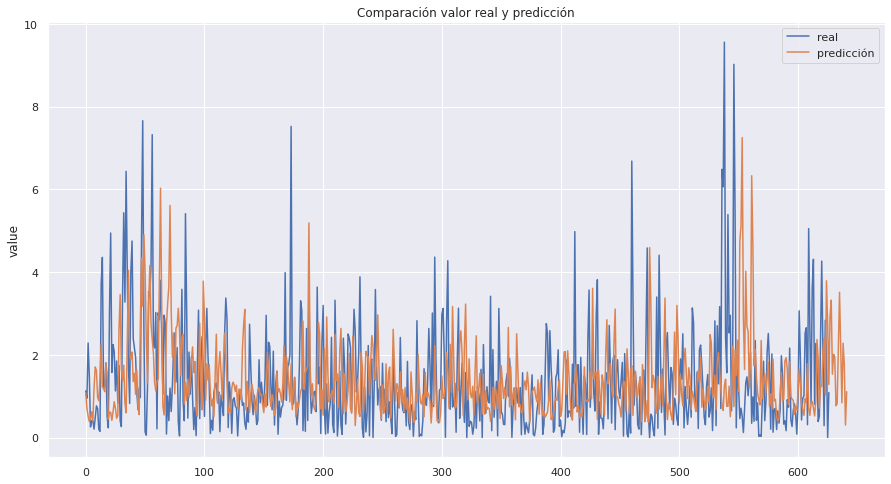

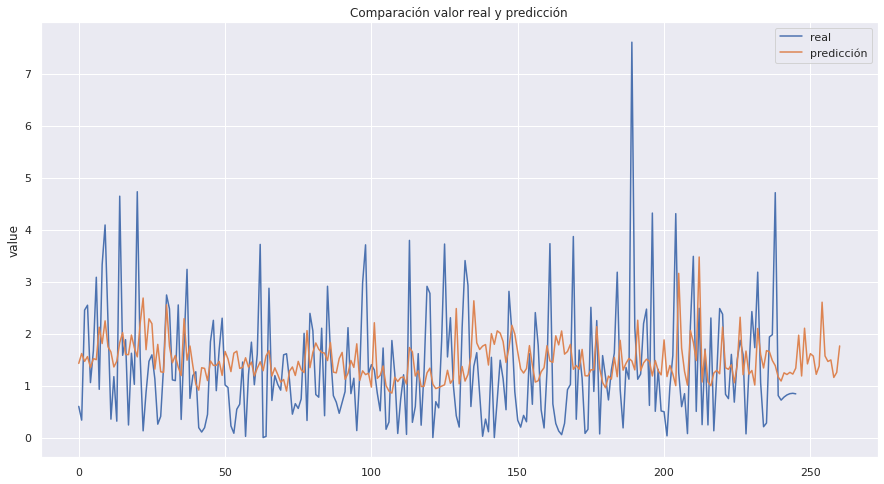

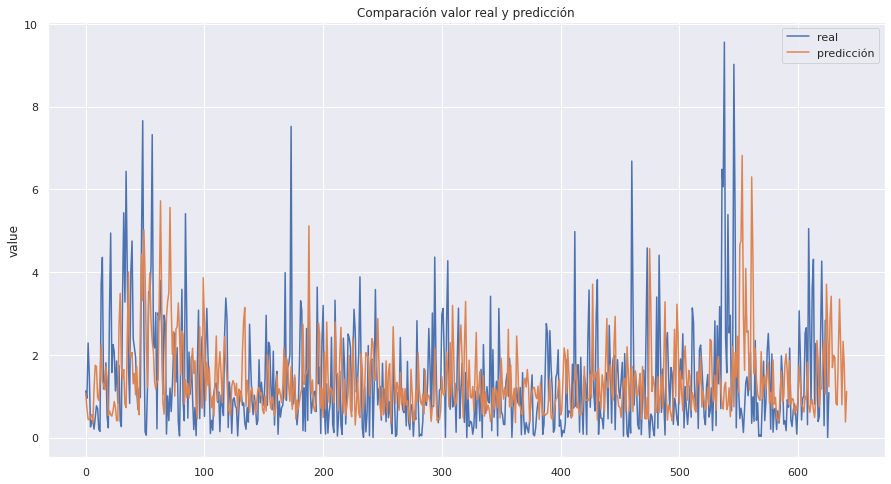

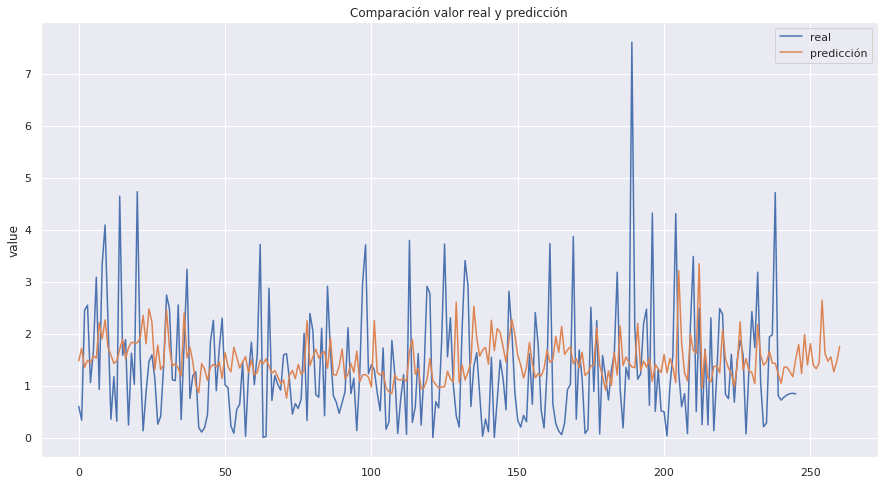

In [11]:
lags=[3,5,7,8,10,15]
n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)